<a href="https://colab.research.google.com/github/aravind5328/projectcode/blob/main/Leveraging_CNN_for_classifying_Lymphoma_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    total_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)
    print('\nImages ready for training : ',end='')
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path+"/"+"train")

    train_datagen = ImageDataGenerator()

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path+"/"+"train",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Validtion : ", end=" ")
    valid_datagen = ImageDataGenerator()
    validation_generator = valid_datagen.flow_from_directory(
        base_path+"/"+"val",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',shuffle=False)
    test_datagen = ImageDataGenerator()
    print('\nFor Testing : ',end='')
    test_generator = test_datagen.flow_from_directory(
        base_path+"/"+"test",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', shuffle=False)
    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break

    return noOfClasses,class_names, train_generator, validation_generator,test_generator

In [ ]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [ ]:
def initiateParams(className, model, lr,model_name):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + model_name+'.h5', verbose=1, save_best_only=True)

    return model, annealer, checkpoint

In [ ]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )

    return history


In [ ]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [ ]:
def evalModel(model):
    evl = model.evaluate(test_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    return acc

def saveModel(model, className,model_name):
    model.save(className + " - "+model_name+"Final.h5")
    print("Model Saved!")

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [ ]:
from sklearn.metrics import recall_score,precision_score,f1_score
def callPlot(model, className, classes):
    y_true = test_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)
    acc=np.trace(conf_mat) / float(np.sum(conf_mat))
    print(f"ACCURACY={acc}")
    recall=recall_score(y_true,y_pred,average='weighted')
    p=precision_score(y_true, y_pred,average='weighted')
    f1=f1_score(y_true, y_pred,average='weighted')

    print(f"RECALL={recall}")
    print(f"precision={p}")
    print(f"F1 Score{f1}")
    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [ ]:
import os
mpath = r"/content/drive/MyDrive"
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 50
lr = 0.001

In [ ]:
import pprint
part={}
for c in classPaths:
#     part[c]={'models':{"EfficientNetB7":{"model":None,"accurary":0},
#                     "Densenet201":{"model":None,"accurary":0},
#                     "VGG19":{"model":None,"accurary":0},
#                     "ResnetV2":{"model":None,"accurary":0},
#                     "mobilenetV3":{"model":None,"accurary":0}
#                    },'no_of_classes':0,"ClassNames":None}
    part[c]={'models':{},'no_of_classes':0,"ClassNames":None}

In [ ]:
pprint.pprint(part)

{'Colab Notebooks': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'GANs': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Lymphoma': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Lymphoma_Dataset': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'TrainedModels': {'ClassNames': None, 'models': {}, 'no_of_classes': 0}}


In [ ]:
for c in classPaths:
    print(c)

Colab Notebooks
TrainedModels
GANs
Lymphoma_Dataset
Lymphoma


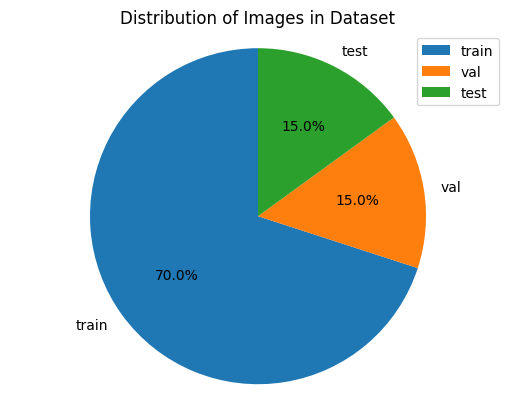

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
1               train                          10500     
2               val                            2250      
3               test                           2250      
------------------------------------------------------------
Total                                         15000     


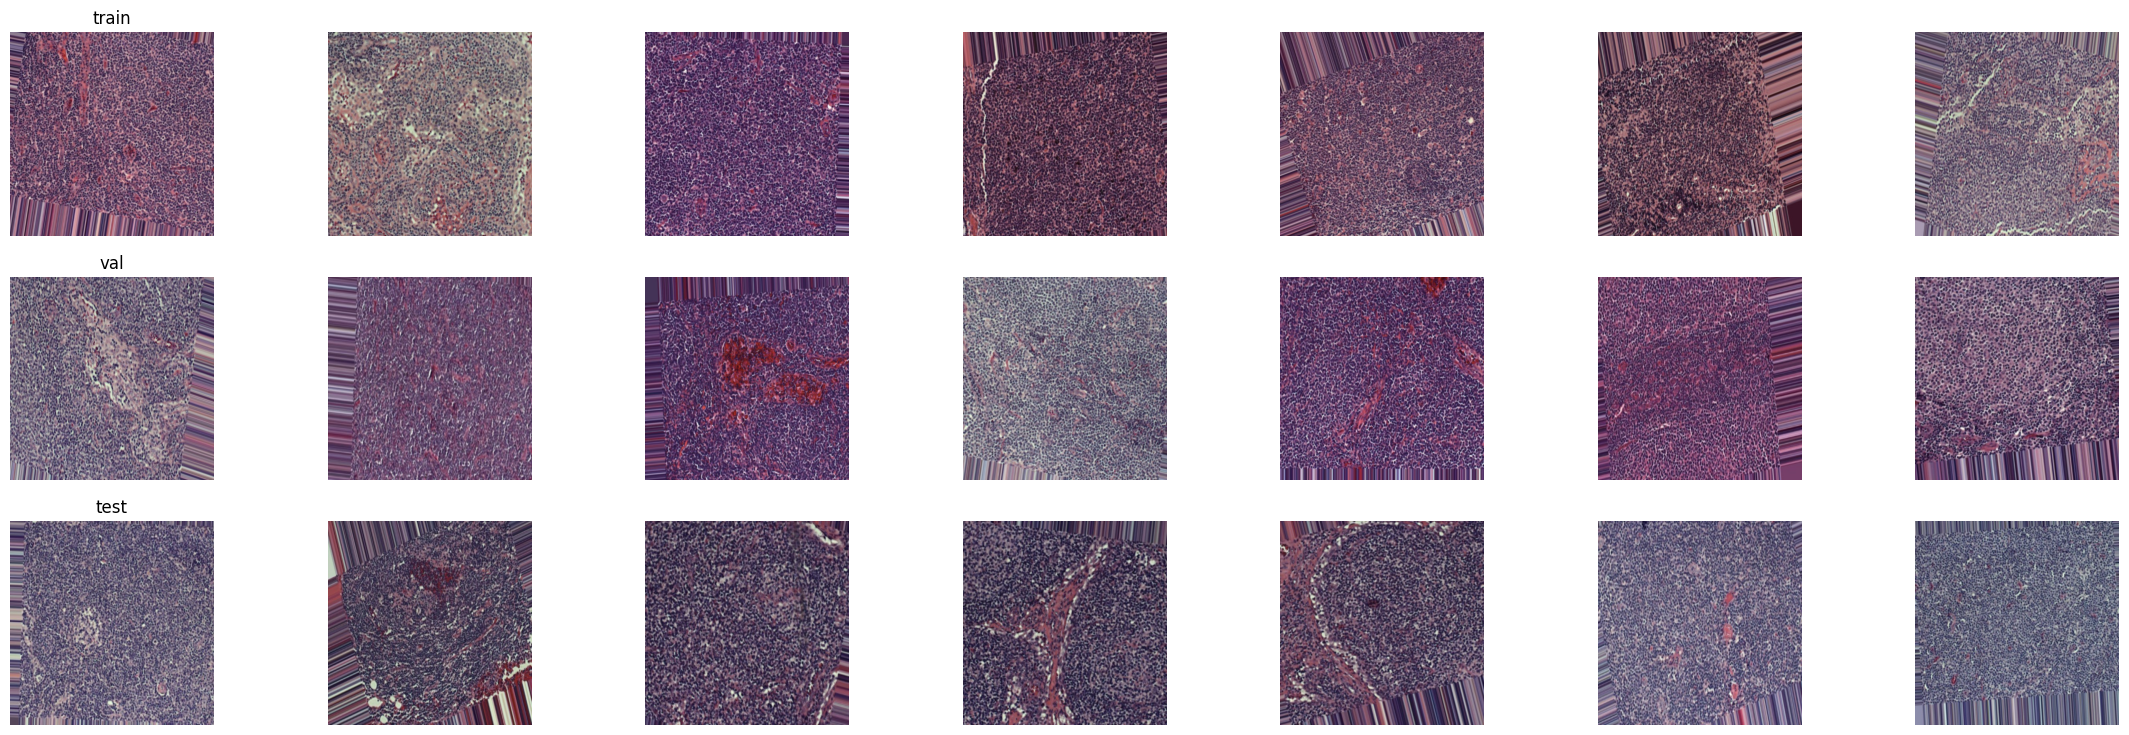

In [ ]:
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image


npath = r'/content/drive/My Drive/Lymphoma'

main_classes = os.listdir(npath)

class_counts = []
for main_class in main_classes:
    main_class_path = os.path.join(npath, main_class)
    num_images = sum([len(files) for _, _, files in os.walk(main_class_path)])
    class_counts.append(num_images)

plt.pie(class_counts, labels=main_classes, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Images in Dataset')
plt.legend(main_classes)
plt.show()

dfs = []

total_count = 0
for main_class_label, main_class_name in enumerate(main_classes, start=1):
    main_class_path = os.path.join(npath, main_class_name)
    num_images = sum([len(files) for _, _, files in os.walk(main_class_path)])
    total_count += num_images
    df_class = pd.DataFrame({'Class Label': [main_class_label], 'Class Name': [main_class_name], 'Count': [num_images]})
    dfs.append(df_class)

df_summary = pd.concat(dfs, ignore_index=True)


print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for index, row in df_summary.iterrows():
    print(f"{row['Class Label']:<15} {row['Class Name']:<30} {row['Count']:<10}")
print("-" * 60)
print(f"{'Total':<45} {total_count:<10}",end='\n')

n_samples = 7

main_classes = os.listdir(npath)

dfs = []

for main_class_label, main_class_name in enumerate(main_classes, start=1):
    main_class_path = os.path.join(npath, main_class_name)

    sub_classes = os.listdir(main_class_path)

    sub_dfs = []

    for sub_class_label, sub_class_name in enumerate(sub_classes, start=1):
        sub_class_path = os.path.join(main_class_path, sub_class_name)

        img_paths = [os.path.join(sub_class_path, img) for img in os.listdir(sub_class_path)]
        img_samples = []

        for img_path in img_paths[:n_samples]:
            img = Image.open(img_path)
            img_samples.append({'label': sub_class_label, 'image': img})

        df_sub_class = pd.DataFrame(img_samples)
        sub_dfs.append(df_sub_class)

    df_main_class = pd.concat(sub_dfs, ignore_index=True)

    dfs.append(df_main_class)

df = pd.concat(dfs, ignore_index=True)

label_map = {label: class_name for label, class_name in enumerate(main_classes, start=1)}

fig, m_axs = plt.subplots(len(main_classes), n_samples, figsize=(4 * n_samples, 3 * len(main_classes)))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx]
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

plt.show()


In [ ]:
def initiateEfficientNetB0(noOfClasses):
    modelInput = tf.keras.applications.EfficientNetB0(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights='imagenet'
    )

    for layer in modelInput.layers:
        layer.trainable = False
    x = Flatten()(modelInput.output)
    x = GlobalAveragePooling2D()(modelInput.output)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model


/content/drive/MyDrive/Lymphoma

Total :  Found 15000 files belonging to 3 classes.

Images ready for training : Found 10500 files belonging to 3 classes.

For Training :  Found 10500 images belonging to 3 classes.

For Validtion :  Found 2250 images belonging to 3 classes.

For Testing : Found 2250 images belonging to 3 classes.

No of Classes :  3
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Image Shape :  (32, 256, 256, 3)
######################################################
RESULTS FOREfficientNetB0
16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/50
329/329 [==============================] - ETA: 0s - loss: 0.7534 - accuracy: 0.6950 
Epoch 1: val_loss improved from inf to 0.44796, saving model to LymphomaEfficientNetB0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


329/329 [==============================] - 4773s 14s/step - loss: 0.7534 - accuracy: 0.6950 - val_loss: 0.4480 - val_accuracy: 0.8396 - lr: 0.0010
Epoch 2/50
329/329 [==============================] - ETA: 0s - loss: 0.5156 - accuracy: 0.7865
Epoch 2: val_loss did not improve from 0.44796
329/329 [==============================] - 93s 281ms/step - loss: 0.5156 - accuracy: 0.7865 - val_loss: 0.4828 - val_accuracy: 0.8067 - lr: 0.0010
Epoch 3/50
329/329 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.8176
Epoch 3: val_loss did not improve from 0.44796
329/329 [==============================] - 92s 280ms/step - loss: 0.4565 - accuracy: 0.8176 - val_loss: 0.5359 - val_accuracy: 0.7724 - lr: 0.0010
Epoch 4/50
329/329 [==============================] - ETA: 0s - loss: 0.4201 - accuracy: 0.8305
Epoch 4: val_loss improved from 0.44796 to 0.37986, saving model to LymphomaEfficientNetB0.h5
329/329 [==============================] - 90s 273ms/step - loss: 0.4201 - accuracy

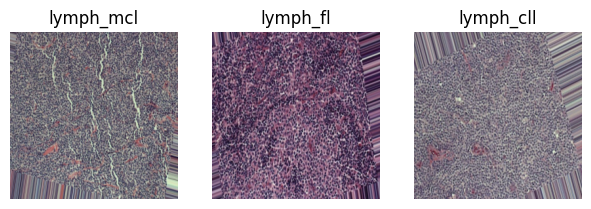

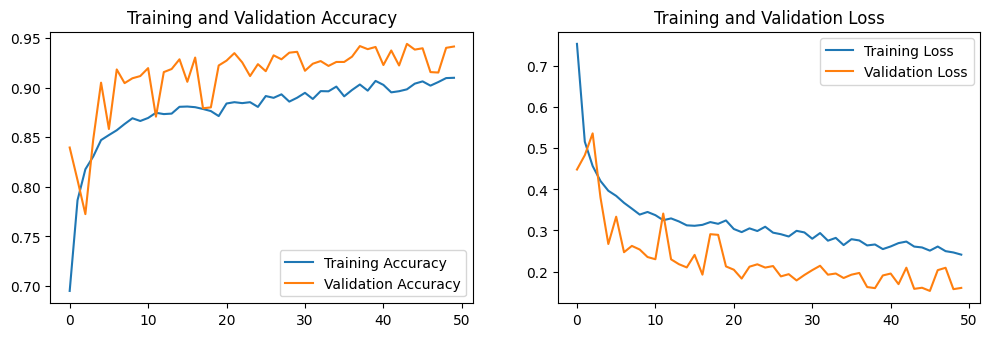

71/71 [==============================] - 1181s 17s/step - loss: 0.1336 - accuracy: 0.9516
Accuracy on the Test Set = 95.16 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
71/71 [==============================] - 18s 231ms/step
Predicted :  [0 0 0 ... 2 2 2]
ACCURACY=0.9515555555555556
RECALL=0.9515555555555556
precision=0.9518367088087906
F1 Score0.9515763281739934


<Figure size 640x480 with 0 Axes>

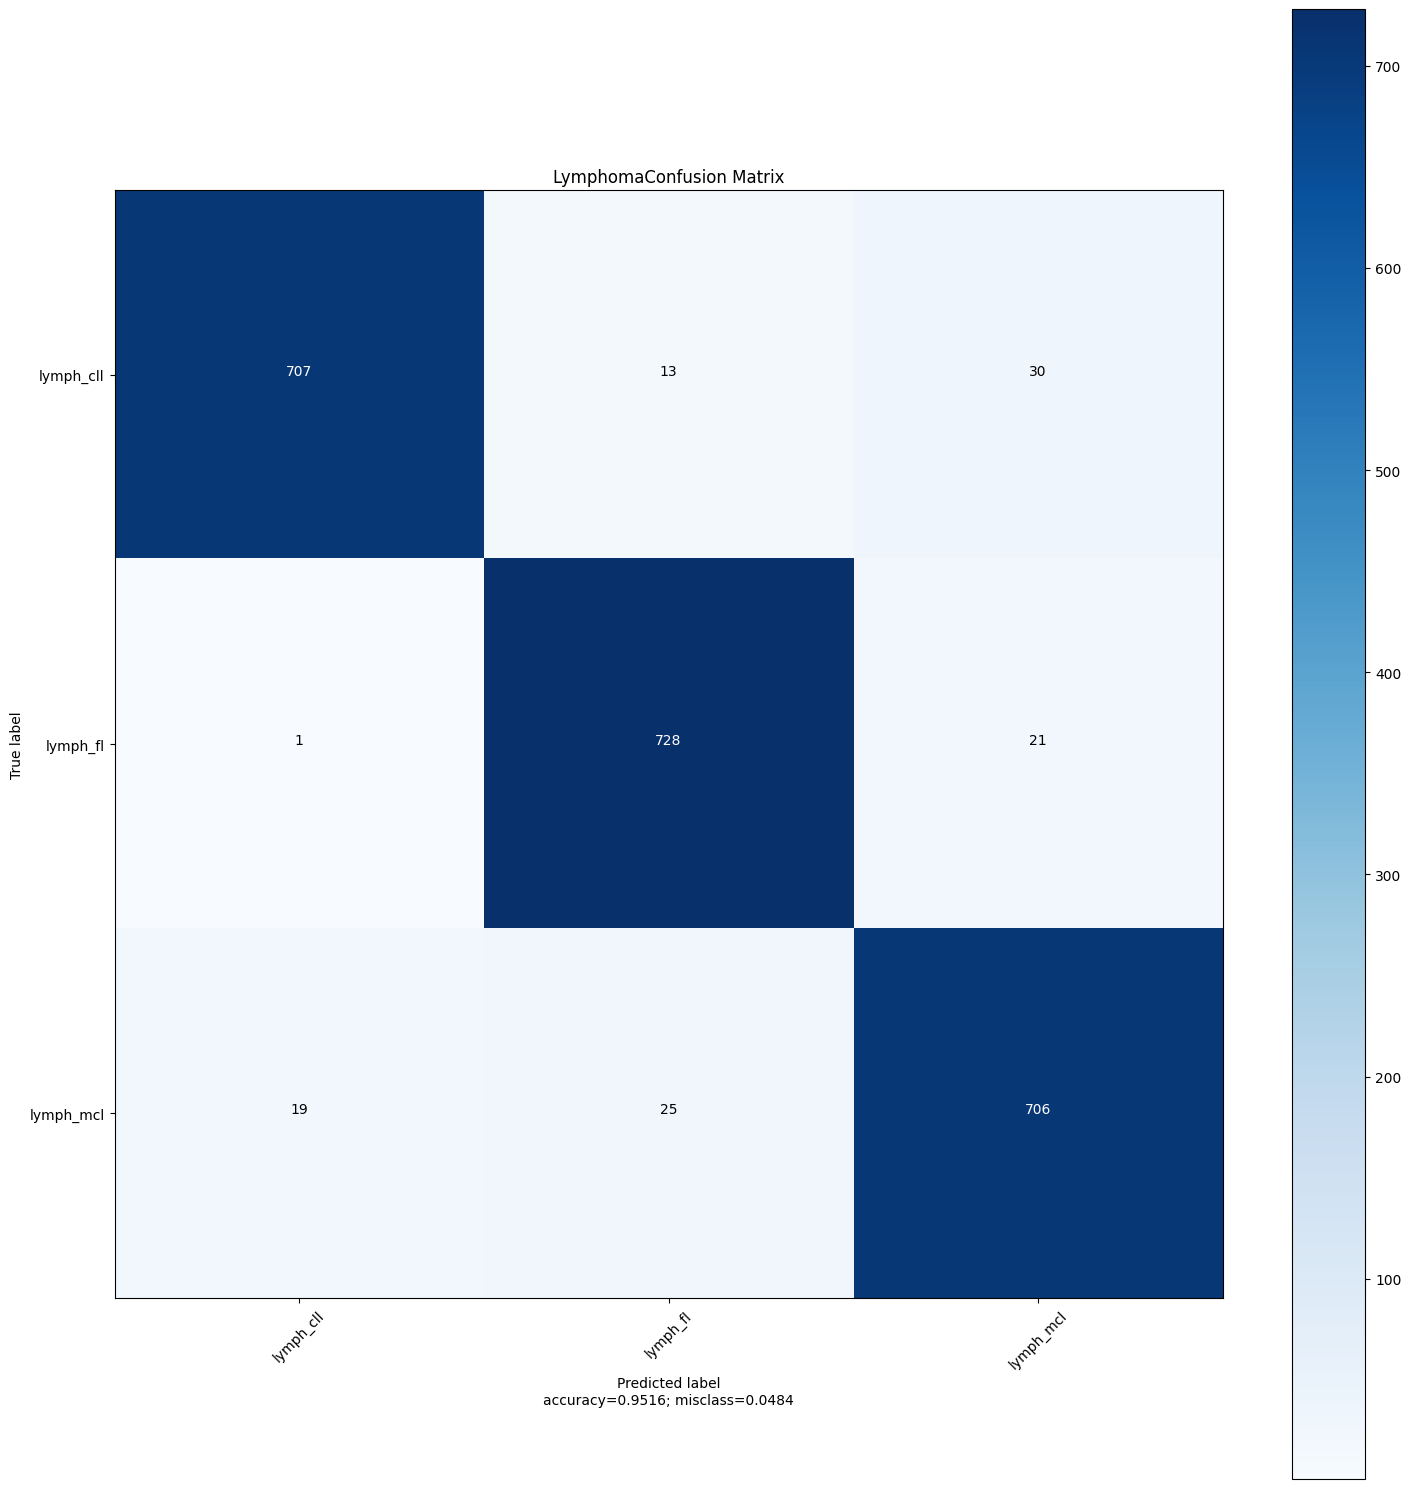

<Figure size 640x480 with 0 Axes>

In [ ]:
for c in classPaths[4:]:
    className = c
#     model_name="EfficientNetB0"
    cpath = os.path.join(mpath, c)
    print(cpath)
    noOfClasses, class_names, train_generator, validation_generator,test_generator = initiateGenerator(cpath)
    part[c]['ClassNames']=class_names
    model_name="EfficientNetB0"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curEfficientNetB0= initiateEfficientNetB0(noOfClasses)
    #modelSummary(curEfficientNetB0)
    curEfficientNetB0, annealer, checkpoint = initiateParams(className, curEfficientNetB0, lr,model_name)
    curHistory = modelFit(curEfficientNetB0, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curEfficientNetB0)
    saveModel(curEfficientNetB0, className,model_name)
    part[c]['models']['EfficientNetB0']={"model":curEfficientNetB0,'Accurary':acc}
    callPlot(curEfficientNetB0, className, class_names)


